## Set up Notebook

In [193]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import re
# 3rd party: 'pip install tweepy'
import tweepy
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## Gather Data

#### *WeRateDogs Twitter Archive*
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

In [103]:
# Load WeRateDogs Twitter Archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### *Tweet Image Predictions*
Every image in the WeRateDogs Twitter archive was run through a neural network that classified breeds of dogs. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [104]:
# Create function for Downloading file off the web
def download_file(url):
    filename = url.split('/')[-1]
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

In [105]:
download_file('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [106]:
tweet_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

#### *Twitter API Data*
Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. The Twitter API will allow me to gather this valuable data.

In [3301]:
# Twitter API login. You must enter your own credentials below in order for the code to run.
consumer_key = ''     # enter your own comsumer_key
consumer_secret = ''  # enter your own comsumer_secret
access_token = ''     # enter your own access_token
access_secret = ''    # enter your own access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# Get statuses for tweets from 'twitter-archive-enhanced.csv'
twitter_archive_ids = twitter_archive['tweet_id']
twitter_archive_statuses = []
for tweet_id in twitter_archive_ids:
    try:
        tweet_status = api.get_status(tweet_id, wait_on_rate_limit=True,
                                      wait_on_rate_limit_notify=True, 
                                      tweet_mode='extended')._json
        print(tweet_id)
    except tweepy.TweepError as e:
        tweet_status = str(tweet_id)
        print(tweet_id, '- Tweet Deleted')
    twitter_archive_statuses.append(tweet_status)

In [3303]:
# Get statuses for most recent tweets'(additional ~3,000 tweets)'
twitter_recent_statuses = []
for status in tweepy.Cursor(api.user_timeline, screen_name='dog_rates',
                            wait_on_rate_limit=True,
                            wait_on_rate_limit_notify=True, 
                            tweet_mode='extended').items():
    
    twitter_recent_statuses.append(status._json)

In [3304]:
# Write 'twitter_archive_statuses' to  .txt file
json_data = {'twitter_archive_statuses': twitter_archive_statuses,
             'twitter_recent_statuses': twitter_recent_statuses}

with open('tweet_json.txt', 'w') as outfile:
    json.dump(json_data, outfile, indent=2)

In [107]:
# Extract ID, Image url, Retweet count, and Favorites count for Twitter Archive Tweets
with open('tweet_json.txt') as file:
    tweet_json = json.load(file)
    
twitter_archive_metrics = []
for status in tweet_json['twitter_archive_statuses']:
    try:
        tweet_id = status['id']
        image_url = status['entities']['media'][0]['media_url_https']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']

    except TypeError:
        tweet_id = int(status)
        image_url = None
        retweet_count = None
        favorite_count = None
        
    except KeyError:
        tweet_id = status['id']
        image_url = 'No Image'
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
    twitter_archive_metrics.append({'tweet_id': tweet_id,
                                    'image_url': image_url,
                                    'retweet_count': retweet_count,
                                    'favorite_count': favorite_count})

twitter_archive_metrics = pd.DataFrame.from_dict(twitter_archive_metrics).reindex(columns=['tweet_id', 
                                                                                           'image_url', 
                                                                                           'retweet_count', 
                                                                                           'favorite_count'])

## Assess Data

In [108]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [109]:
tweet_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [110]:
twitter_archive_metrics.head()

,tweet_id,image_url,retweet_count,favorite_count
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8776.0,39301.0
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6426.0,33659.0
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4268.0,25354.0
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8861.0,42678.0
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,9643.0,40836.0


In [111]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [112]:
tweet_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [113]:
twitter_archive_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
tweet_id          2356 non-null int64
image_url         2349 non-null object
retweet_count     2349 non-null float64
favorite_count    2349 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 73.7+ KB


>**tweet_image_predictions** contains 281 fewer rows of data than **twitter_archive** and **twitter_archive_metrics**.

In [114]:
# Identify tweet IDs within 'twitter_archive' that are not in 'tweet_image_predictions'
twitter_archive_excluded = twitter_archive[~twitter_archive['tweet_id'].isin(tweet_image_predictions['tweet_id'])]

twitter_archive_excluded.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


In [115]:
twitter_archive_excluded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 30 to 2298
Data columns (total 17 columns):
tweet_id                      281 non-null int64
in_reply_to_status_id         55 non-null float64
in_reply_to_user_id           55 non-null float64
timestamp                     281 non-null object
source                        281 non-null object
text                          281 non-null object
retweeted_status_id           100 non-null float64
retweeted_status_user_id      100 non-null float64
retweeted_status_timestamp    100 non-null object
expanded_urls                 222 non-null object
rating_numerator              281 non-null int64
rating_denominator            281 non-null int64
name                          281 non-null object
doggo                         281 non-null object
floofer                       281 non-null object
pupper                        281 non-null object
puppo                         281 non-null object
dtypes: float64(4), int64(3), object(10)
mem

In [116]:
# Pull 'twitter_archive_metrics' for tweet IDs within 'twitter_archive_excluded'
twitter_archive_excluded_metrics = twitter_archive_metrics[twitter_archive_metrics['tweet_id'] \
                                                           .isin(twitter_archive_excluded['tweet_id'])]

twitter_archive_excluded_metrics.head()

,tweet_id,image_url,retweet_count,favorite_count
30,886267009285017600,No Image,4.0,117.0
32,886054160059072513,No Image,106.0,0.0
35,885518971528720385,No Image,3858.0,20661.0
42,884247878851493888,No Image,20973.0,73889.0
55,881633300179243008,No Image,7.0,129.0


In [117]:
twitter_archive_excluded_metrics['image_url'].value_counts() 
# Still missing 2 tweets from 'twitter_archive' not present in 'tweet_image_predictions'

No Image    279
Name: image_url, dtype: int64

In [118]:
# Identify remaining Tweet IDs from 'twitter_archive' not appearing on 'tweet_image_predictions'/'twitter_archive_metrics'
twitter_archive_excluded_metrics[twitter_archive_excluded_metrics['image_url'].isnull()]

,tweet_id,image_url,retweet_count,favorite_count
118,869988702071779329,None,NaN,NaN
784,775096608509886464,None,NaN,NaN


In [119]:
# Identity retweets from 'twitter_arhcive'
twitter_archive_retweets = twitter_archive[~twitter_archive['retweeted_status_id'].isnull()]
twitter_archive_retweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


In [120]:
# Identiy retweets from 'tweet_image_predictions'
twitter_archive_retweets[twitter_archive_retweets['tweet_id'].isin(tweet_image_predictions['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
130,867072653475098625,NaN,NaN,2017-05-23 17:40:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachaeleasler: these @dog_rates hats are 1...,8.650134e+17,7.874618e+17,2017-05-18 01:17:25 +0000,https://twitter.com/rachaeleasler/status/86501...,13,10,None,None,None,None,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None
160,860924035999428608,NaN,NaN,2017-05-06 18:27:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @tallylott: h*ckin adorable promposal. 13/1...,8.609145e+17,3.638908e+08,2017-05-06 17:49:42 +0000,https://twitter.com/tallylott/status/860914485...,13,10,None,None,None,None,None
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Astrid. She's a guide d...,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,https://twitter.com/dog_rates/status/829374341...,13,10,Astrid,doggo,None,None,None
212,851861385021730816,NaN,NaN,2017-04-11 18:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @eddie_coe98: Thanks @dog_rates completed m...,8.482894e+17,3.410211e+08,2017-04-01 21:42:03 +0000,https://twitter.com/eddie_coe98/status/8482893...,10,10,None,None,None,None,None
231,847971574464610304,NaN,NaN,2017-04-01 00:39:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @basic_vacek_: I love my new mug easy 13/10...,8.479710e+17,5.970642e+08,2017-04-01 00:36:55 +0000,https://twitter.com/basic_vacek_/status/847971...,13,10,None,None,None,None,None


In [121]:
# Identify deleted tweets from 'twitter_archive'. No tweet Status data found in API.
deleted_tweets = twitter_archive_metrics[twitter_archive_metrics['retweet_count'].isnull()]
deleted_tweets = deleted_tweets['tweet_id'].tolist()
deleted_tweets

[888202515573088257,
 873697596434513921,
 869988702071779329,
 861769973181624320,
 842892208864923648,
 802247111496568832,
 775096608509886464]

In [122]:
# Review detail of deleted tweets in 'twitter_archive' table
twitter_archive[twitter_archive['tweet_id'].isin(deleted_tweets)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,None,None,None,None
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
566,802247111496568832,NaN,NaN,2016-11-25 20:26:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everybody drop what you're doin...,7.790561e+17,4.196984e+09,2016-09-22 20:33:42 +0000,https://twitter.com/dog_rates/status/779056095...,13,10,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [123]:
# Identify deleted tweets within 'tweet_image_predictions' table
tweet_image_predictions[tweet_image_predictions['tweet_id'].isin(deleted_tweets)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1615,802247111496568832,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,1,Chihuahua,0.721188,True,toy_terrier,0.112943,True,kelpie,0.053365,True
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [124]:
# Check for duplicate Tweet IDs
sum(twitter_archive['tweet_id'].duplicated())

0

In [125]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [126]:
tweet_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Quality

##### `twitter_archive` Table
-  Contains 281 tweets that are missing from `tweet_image_predictions` **Exclude from report**
    -  279 tweets with no image/is retweet
    -  2 tweets deleted from 'twitter_archive_metrics'
-  Contains 7 tweet IDs that have been deleted from Twitter (includes 2 deleted tweets from above) **Exclude from report**
-  Contains 181 tweet IDs that are retweets **Exclude from report**
    -  Remove 'retweet' columns
-  Some ratings are incorrect
-  Some names are incorrect
-  Some tweets referring to multiple dogs do not have a dog_style assigned

##### `tweet_image_predictions` Table
-  Missing 281 tweets that are present in 'twitter_archive (see above)
-  Contains 5 tweet IDs that have been deleted from Twitter (twitter_archive_metrics) **Exclude from report**
-  Contains 81 tweet IDs that are retweets **Exclude from report**

##### `twitter_archive_metrics` Table
-  Missing retweet_count and favorite_count data for 7 tweets listed on 'twitter_archive'

#### Tidiness

-  retweet_count and favorite_count from 'twitter_archive_metrics' should be part of 'twitter_archive' table

-  p1 and p1_conf from 'tweet_image_predictions' should be part of 'twitter_archive table

-  'doggo', 'floofer', 'pupper', 'puppo' columns in `twitter_archive` should be combined into one column


## Clean Data

In [135]:
# Create copies of dataframes
twitter_archive_clean = twitter_archive.copy()
tweet_image_predictions_clean = tweet_image_predictions.copy()
twitter_archive_metrics_clean = twitter_archive_metrics.copy()

### Tidiness

**Issue:**

-  retweet_count and favorite_count should be part of 'twitter_archive' table


**Define:**

Merge retweet_count and and favorites_count from 'twitter_archive_metrics' to the 'twitter_archive_clean' table.

**Code:**

In [136]:
twitter_archive_clean = pd.merge(twitter_archive_clean, 
                                 twitter_archive_metrics[['tweet_id','retweet_count','favorite_count']], 
                                 how='inner', on='tweet_id')

**Test:**

In [137]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8776.0,39301.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6426.0,33659.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4268.0,25354.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8861.0,42678.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9643.0,40836.0


In [138]:
twitter_archive_clean.info()
# retweet_count and favorite_count have been added and number of rows still = 2356

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

**Issue:**

-  p1 and p1_conf from 'tweet_image_predictions' should be part of 'twitter_archive table

**Define:**

Merge p1 and and p1_conf from 'tweet_image_predictions' to the 'twitter_archive_clean' table.

**Code:**

In [139]:
twitter_archive_clean = pd.merge(twitter_archive_clean, 
                                 tweet_image_predictions[['tweet_id','p1','p1_conf']], 
                                 how='inner', on='tweet_id')

**Test**

In [140]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,p1,p1_conf
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,8776.0,39301.0,orange,0.097049
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,6426.0,33659.0,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,None,None,None,4268.0,25354.0,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,None,None,None,None,8861.0,42678.0,paper_towel,0.170278
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,None,None,None,None,9643.0,40836.0,basset,0.555712


In [142]:
# Check for null values in 'p1' column
twitter_archive_clean[twitter_archive_clean['p1'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,p1,p1_conf


**Issue:**

-  'doggo', 'floofer', 'pupper', 'puppo' columns in `twitter_archive` should be combined into one column

**Define:**

Melt 'doggo', 'floofer', 'pupper', and 'puppo' columns into one column named 'dog_style' then reassign dog styles since some values get removed in the melting process. If multiple dog styles were mentioned in the 'text' column, the first style will be used.

**Code:**

In [143]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id', 
                                                                'in_reply_to_status_id', 
                                                                'in_reply_to_user_id', 
                                                                'timestamp', 
                                                                'source', 
                                                                'text',
                                                                'retweeted_status_id',
                                                                'retweeted_status_user_id',
                                                                'retweeted_status_timestamp',
                                                                'expanded_urls', 
                                                                'rating_numerator', 
                                                                'rating_denominator', 
                                                                'name',
                                                                'retweet_count', 
                                                                'favorite_count',
                                                                'p1',
                                                                'p1_conf'],
                                var_name='styles', value_name='dog_style').drop('styles', axis=1)

In [144]:
# Remove duplicate tweet_ids
twitter_archive_clean = twitter_archive_clean.drop_duplicates(subset='tweet_id', keep='first')

In [145]:
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('doggo', case=False), 
                                              'doggo', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('floofer', case=False), 
                                              'floofer', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('puppo', case=False), 
                                              'puppo', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('pupper', case=False), 
                                              'pupper', twitter_archive_clean['dog_style'])

**Test:**

In [146]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [147]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 18 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
retweet_count                 2070 non-null float64
favorite_count                2070 non-null float64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
dog_style                     20

In [148]:
# Test tweet example
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 883360690899218434]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
42,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,3780.0,22831.0,chow,0.987997,floofer


### Qaulity

##### `twitter_archive` Table

**Issue:**
-  Contains 281 tweets that are missing from `tweet_image_predictions` **Exclude from report**
    -  279 tweets with no image/is retweet
    -  2 tweets deleted from 'twitter_archive_metrics'

**Define:**

Update 'twitter_archive_clean' table to ommit tweet IDs that are present in 'twitter_archive_excluded' table

**Code:**

In [149]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(twitter_archive_excluded['tweet_id'])]

**Test:**

In [150]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [151]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 18 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
retweet_count                 2070 non-null float64
favorite_count                2070 non-null float64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
dog_style                     20

**Issue:**

-  Contains 7 tweet IDs that have been deleted from Twitter (includes 2 deleted tweets from above) **Exclude from report**

*2 tweets addressed from above cleaning*

**Define:**

Update 'twitter_archive_clean' table to ommit tweet IDs that are not present in 'deleted_tweets' table

**Code:**

In [152]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(deleted_tweets)]

**Test:**

In [153]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [154]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2070 entries, 0 to 2074
Data columns (total 18 columns):
tweet_id                      2070 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2070 non-null object
source                        2070 non-null object
text                          2070 non-null object
retweeted_status_id           76 non-null float64
retweeted_status_user_id      76 non-null float64
retweeted_status_timestamp    76 non-null object
expanded_urls                 2070 non-null object
rating_numerator              2070 non-null int64
rating_denominator            2070 non-null int64
name                          2070 non-null object
retweet_count                 2070 non-null float64
favorite_count                2070 non-null float64
p1                            2070 non-null object
p1_conf                       2070 non-null float64
dog_style                     20

**Issue:**

-  Contains 181 tweet IDs that are retweets **Exclude from report**. 

*Some items were resolved during above cleaning.*

**Define:**

Updated 'twitter_archive_clean' table to ommit tweet IDs where *retweeted_status_id* column is not NaN, then drop 'retweet' related columns

**Code:**

In [155]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]

In [156]:
twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id',
                                                    'retweeted_status_user_id',
                                                    'retweeted_status_timestamp'], axis=1)

**Test:**

In [157]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [158]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 15 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
retweet_count            1994 non-null float64
favorite_count           1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
dog_style                1994 non-null object
dtypes: float64(5), int64(3), object(7)
memory usage: 249.2+ KB


**Issue:**

-  Some ratings are incorrect

**Define:**

Use regex to extract rating_numerator and rating_denominator from text and create a 'dog_rating_df' dataframe. If multiple ratings (ex. tweet_id - 695064344191721472), use second rating.

After dog_rating dataframe is created, replace rating (numerator and denomenator) in 'twitter_archive_clean' with rating_numerator and rating_denominator from 'dog_rating_df'.

**Code:**

In [159]:
# Create the dog_rating dataframe
dog_rating = []
for index, item in twitter_archive_clean.iterrows():
    tweet_id = item['tweet_id']
    rating_numerator = re.findall('(\s?\d+\.?\/)', item['text'])[-1:][0]
    rating_denominator = re.findall('([^a-zA-Z]\/\d+[^a-rt-z-zA-Z0-9])', item['text'])[-1:][0]
    dog_rating.append({'tweet_id' : tweet_id,
                       'rating_numerator_new': rating_numerator[:-1].strip(),
                       'rating_denominator_new' : rating_denominator[2:-1].strip()})

dog_rating_df = pd.DataFrame(dog_rating)

In [160]:
# Replace old rating_numerator and rating_denominator values in 'twitter_archive_clean' with new numerator
# denominator values from 'dog_rating_df'.
twitter_archive_clean['rating_numerator'] = dog_rating_df['rating_numerator_new'].values
twitter_archive_clean['rating_denominator'] = dog_rating_df['rating_denominator_new'].values

**Test:**

In [161]:
dog_rating_df.head()

,rating_denominator_new,rating_numerator_new,tweet_id
0,10,13,892420643555336193
1,10,13,892177421306343426
2,10,12,891815181378084864
3,10,13,891689557279858688
4,10,12,891327558926688256


In [162]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [163]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 15 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null object
rating_denominator       1994 non-null object
name                     1994 non-null object
retweet_count            1994 non-null float64
favorite_count           1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
dog_style                1994 non-null object
dtypes: float64(5), int64(1), object(9)
memory usage: 249.2+ KB


In [164]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(int)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(int)

In [165]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 15 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int32
rating_denominator       1994 non-null int32
name                     1994 non-null object
retweet_count            1994 non-null float64
favorite_count           1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
dog_style                1994 non-null object
dtypes: float64(5), int32(2), int64(1), object(7)
memory usage: 233.7+ KB


In [166]:
# Review rating for previously incorrect tweet_id (previous rating was 4/10)
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 695064344191721472] 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
1231,695064344191721472,NaN,NaN,2016-02-04 02:00:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,13,10,None,674.0,1751.0,seat_belt,0.522211,None


In [167]:
# Check for null rating values
twitter_archive_clean[twitter_archive_clean['rating_numerator'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style


**Issue:**

-  Some names are incorrect ('a', 'an', 'the', 'very', etc)

**Define:**

Identify valid names as beginning with a captial letter. Any name starting with a lower case letter will be changed to 'None'

**Code:**

In [168]:
twitter_archive_clean['name'] = np.where(twitter_archive_clean['name'].str.islower(), 'None', twitter_archive_clean['name'])

**Test:**

In [169]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [170]:
# Test example of dog name which was previously 'very'
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 883360690899218434] # Name is now 'None'

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
42,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,3780.0,22831.0,chow,0.987997,floofer


In [171]:
# Review names that set a 'None'
twitter_archive_clean[twitter_archive_clean['name'] == 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,3211.0,20468.0,Chesapeake_Bay_retriever,0.425595,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,19417.0,66389.0,Pomeranian,0.566142,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,https://twitter.com/dog_rates/status/889665388...,13,10,None,9894.0,46138.0,Pembroke,0.966327,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14,10,None,11970.0,46761.0,limousine,0.130432,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,https://twitter.com/dog_rates/status/887343217...,13,10,None,10644.0,34082.0,Mexican_hairless,0.330741,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,10,None,6112.0,30934.0,Samoyed,0.733942,None
34,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,https://twitter.com/dog_rates/status/885167619...,13,10,None,4492.0,22210.0,malamute,0.812482,None
38,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",https://twitter.com/dog_rates/status/884441805...,14,10,None,5805.0,27336.0,Pembroke,0.993225,None
43,883117836046086144,NaN,NaN,2017-07-07 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please only send dogs. We don't rate mechanics...,https://twitter.com/dog_rates/status/883117836...,13,10,None,6858.0,37691.0,golden_retriever,0.949562,None
51,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14,10,None,16442.0,50077.0,Samoyed,0.281463,pupper


>Becuase the text in the 'text' column did not always follow a consistent pattern and sometimes used unorthodox sentences (ie. "HI. MY. NAME. IS. BOOMER. AND. I. WANT. TO. SA..."), it was difficult to use regex or other 'find' methods in a consistent manner to extract dog names. I could not find a 'catch-all' method that would fit every senario in which a dog's name was provided, so there are instences in which a dog name was provided somewhere in the 'text' column but not identified though the code.

**Issue:**

-  Some tweets referring to multiple dogs do not have a dog_style assigned.

**Define:**

Search 'text' column for plural versions of 'dog_style' and update 'dog_style' column accordingly

**Code:**

In [172]:
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('doggos'), 
                                              'doggo', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('floofers'), 
                                              'floofer', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('puppos'), 
                                              'puppo', twitter_archive_clean['dog_style'])
twitter_archive_clean['dog_style'] = np.where(twitter_archive_clean['text'].str.contains('puppers'), 
                                              'pupper', twitter_archive_clean['dog_style'])

**Test:**

In [173]:
# Test example of dog_style which was previously 'None'
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 704054845121142784]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
1133,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,None,1019.0,3174.0,Great_Pyrenees,0.667939,pupper


##### `tweet_image_predictions` Table

**Issue:**

-  Contains 5 tweet IDs that have been deleted from Twitter **Exclude from report**

**Define:**

Update 'tweet_image_predictions_clean' table to ommit tweet IDs that are present in 'deleted_tweets' table

**Code:**

In [174]:
tweet_image_predictions_clean = tweet_image_predictions_clean[~tweet_image_predictions_clean['tweet_id'].isin(deleted_tweets)]

**Test:**

In [175]:
tweet_image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [176]:
tweet_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2070 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2070 non-null int64
jpg_url     2070 non-null object
img_num     2070 non-null int64
p1          2070 non-null object
p1_conf     2070 non-null float64
p1_dog      2070 non-null bool
p2          2070 non-null object
p2_conf     2070 non-null float64
p2_dog      2070 non-null bool
p3          2070 non-null object
p3_conf     2070 non-null float64
p3_dog      2070 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 167.8+ KB


**Issue:**

-  Contains 81 tweet IDs that are retweets **Exclude from report**

*5 tweets already resolved from above cleaning*

**Define:**

Update 'tweet_image_predictions_clean' table to ommit tweet IDs that are present in 'twitter_archive_retweets' table

**Code:**

In [177]:
tweet_image_predictions_clean = tweet_image_predictions_clean[~tweet_image_predictions_clean['tweet_id'].isin(twitter_archive_retweets['tweet_id'])]

**Test:**

In [178]:
tweet_image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [179]:
tweet_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    1994 non-null int64
jpg_url     1994 non-null object
img_num     1994 non-null int64
p1          1994 non-null object
p1_conf     1994 non-null float64
p1_dog      1994 non-null bool
p2          1994 non-null object
p2_conf     1994 non-null float64
p2_dog      1994 non-null bool
p3          1994 non-null object
p3_conf     1994 non-null float64
p3_dog      1994 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.6+ KB


### Insights

In [180]:
# Write 'twitter_archive_clean' to a .csv named 'twitter_archive_master'
twitter_archive_clean.to_csv('twitter_archive_master.csv')

In [181]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8776.0,39301.0,orange,0.097049,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6426.0,33659.0,Chihuahua,0.323581,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4268.0,25354.0,Chihuahua,0.716012,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8861.0,42678.0,paper_towel,0.170278,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9643.0,40836.0,basset,0.555712,None


In [182]:
# Compare dog ratings that have a denominator of 10 for evenness (denominators above 10 seem to be outliers)
denominator_ten = twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 10]

In [183]:
denominator_ten['rating_numerator'].value_counts()

12      450
10      412
11      397
13      263
9       150
8        98
7        53
14       36
6        33
5        32
3        19
4        16
2        10
1         5
0         2
420       1
26        1
27        1
75        1
1776      1
Name: rating_numerator, dtype: int64

In [184]:
denominator_ten['rating_numerator'].describe()

count    1981.000000
mean       11.682484
std        40.801672
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

By far, the most frequent ratings were above a 10. This was to be expected since this twitter account is known for regularly giving high ratings.

In [185]:
# Review favorite counts
denominator_ten['favorite_count'].describe()

count      1981.000000
mean       8937.674912
std       12504.403595
min          80.000000
25%        1938.000000
50%        4105.000000
75%       11290.000000
max      131735.000000
Name: favorite_count, dtype: float64

In [186]:
denominator_ten[denominator_ten['favorite_count'] == 131735]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
330,822872901745569793,NaN,NaN,2017-01-21 18:26:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,47649.0,131735.0,Lakeland_terrier,0.196015,puppo


In [187]:
denominator_ten.sort_values(by=['favorite_count'], ascending=False)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,p1,p1_conf,dog_style
330,822872901745569793,NaN,NaN,2017-01-21 18:26:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,47649.0,131735.0,Lakeland_terrier,0.196015,puppo
853,744234799360020481,NaN,NaN,2016-06-18 18:26:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,10,None,78687.0,130017.0,Labrador_retriever,0.825333,doggo
433,807106840509214720,NaN,NaN,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,62163.0,124036.0,Chihuahua,0.505370,None
60,879415818425184262,NaN,NaN,2017-06-26 19:07:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,10,Duddles,45425.0,107344.0,English_springer,0.383404,None
113,866450705531457537,NaN,NaN,2017-05-22 00:28:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,https://twitter.com/dog_rates/status/866450705...,13,10,Jamesy,32499.0,106054.0,French_bulldog,0.905334,pupper
359,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,41817.0,94779.0,standard_poodle,0.351308,doggo
142,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,https://twitter.com/dog_rates/status/859196978...,12,10,None,32376.0,93815.0,Angora,0.224218,None
97,870374049280663552,NaN,NaN,2017-06-01 20:18:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She really likes the planet. Wou...,https://twitter.com/dog_rates/status/870374049...,13,10,Zoey,27335.0,84400.0,golden_retriever,0.841001,None
436,806629075125202948,NaN,NaN,2016-12-07 22:38:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Good afternoon class today we're going to lea...",https://twitter.com/dog_rates/status/806629075...,13,10,None,40253.0,83318.0,Arabian_camel,0.366248,None
67,877736472329191424,NaN,NaN,2017-06-22 03:54:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Aja. She was just told she's a good do...,https://twitter.com/dog_rates/status/877736472...,13,10,Aja,19787.0,81117.0,Chesapeake_Bay_retriever,0.837956,None


In [188]:
# Review tweets by dog breed
denominator_ten['p1'].value_counts()

golden_retriever             136
Labrador_retriever            92
Pembroke                      88
Chihuahua                     79
pug                           54
chow                          41
Samoyed                       40
Pomeranian                    38
toy_poodle                    38
malamute                      29
cocker_spaniel                27
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            22
seat_belt                     21
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     19
Shetland_sheepdog             18
Eskimo_dog                    18
Maltese_dog                   18
Shih-Tzu                      17
teddy                         17
Cardigan                      17
Rottweiler                    17
beagle                        17
Italian_greyhound             16
Lakeland_terrier              16
kuvasz                        16
web_site                      15
          

The most frequently tweeted dog breed seems to be the Golden Retriever and Labrador Retriever. It is clear that the algorithim used to identify dog breeds is slightly flawed in that not every 'breed' listed is actually a type of dog. Some inanimate objects were identified as dog breeds (tricycle, banana,etc.) but the occurrences do not seem to be frequent enough to suggest the top tweeted breeds are not accurate.

In [226]:
# Plot retweets by dog breed
retweets_by_breed = denominator_ten.groupby(['p1'], as_index=False)['retweet_count'].sum().sort_values(['retweet_count'],
                                                                                                       ascending=False)

retweets_by_breed.head()

,p1,retweet_count
183,golden_retriever,499030.0
44,Labrador_retriever,356902.0
58,Pembroke,278584.0
22,Chihuahua,224351.0
64,Samoyed,182642.0


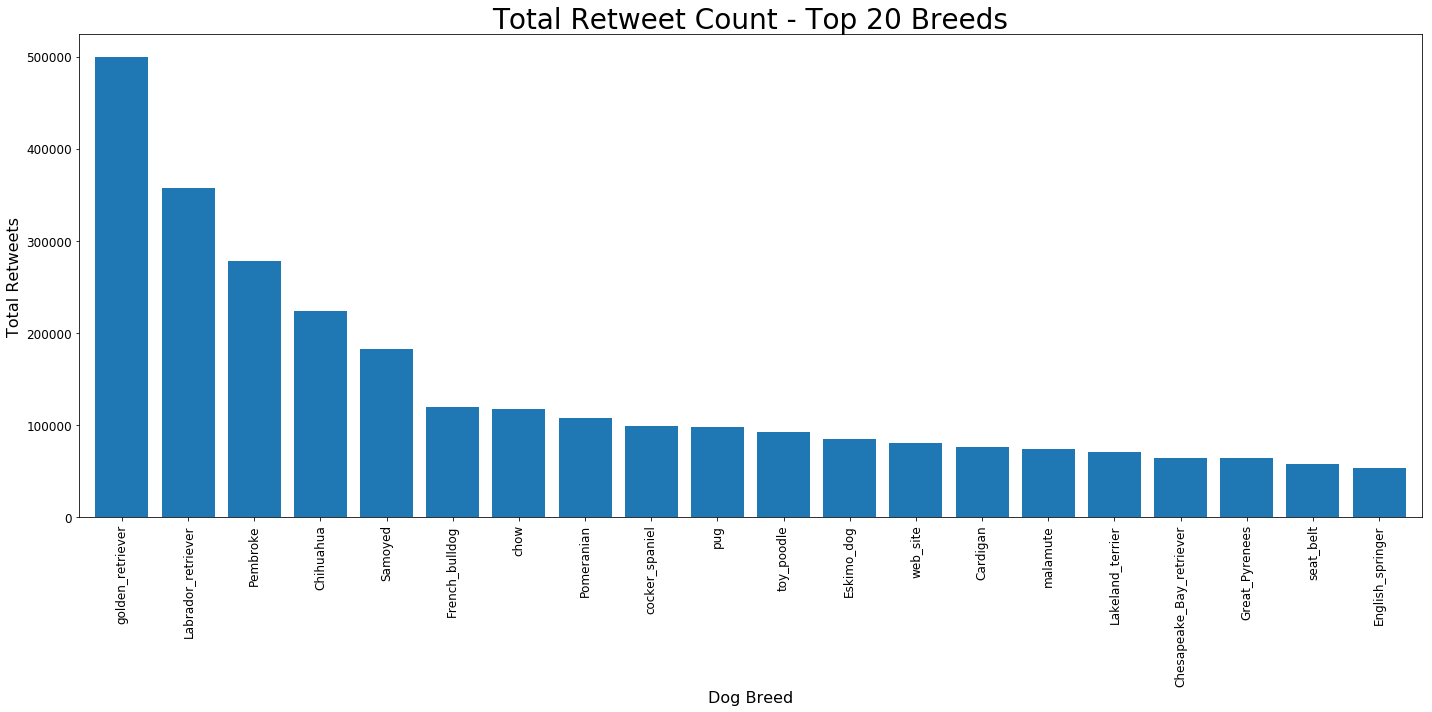

In [244]:
retweets_by_breed_plot = retweets_by_breed[0:20].plot.bar(x = retweets_by_breed['p1'][0:20],
                                                          fontsize=12,
                                                          width=.8,
                                                          alpha = .5
                                                          figsize=(20,10))
retweets_by_breed_plot.set_title('Total Retweet Count - Top 20 Breeds',fontsize=28)
retweets_by_breed_plot.set_xlabel('Dog Breed', fontsize=16)
retweets_by_breed_plot.set_ylabel('Total Retweets', fontsize=16)
retweets_by_breed_plot.legend_.remove()

retweets_by_breed_plot
plt.tight_layout()

In [191]:
fig = retweets_by_breed_plot.get_figure()
fig.tight_layout()
fig.savefig('retweets')